# Dynamic Programming


In this notebook, I will implement:

- DP Policy Evaluation
- DP Policy Improvement 
- DP Policy Iteration 
- DP Value Iteration 

# The Fishlake Environment

You should be familiar with the inner workings of the `Fishlake` Environment from the lecture slides. We will now use this environment to test dynamic programming prediction and control algorithms.

If you `render` the environment, it will look something like this:
```
WWWM
WRWF
SWWW

W ... W.ater (may be very streamy, and mess with the fish's movement)
S ... S.tart (a state in which the fish may start an episode)
R ... R.ock (this is essentially a hole in the map, it is not a state!)

M ... M.aize (delicious fish food; entering this state from any other
              state will give +1 reward, and end the episode)
F ... F.isherman (evil; entering this state from any other state will
                  give -1 reward, and end the episode)
```

<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment and some helper functions. You have to run this cell first, before starting to implement and run your algorithms.

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gym
import fishlake
from fishlake import plot_policy, plot_value_function
import testing
from typing import Tuple

np.set_printoptions(precision=4, suppress=True, threshold=200)



print('numpy version:',np.__version__)
print('matplotlib version:',matplotlib.__version__)
print('gym version:',gym.__version__)

numpy version: 1.21.5
matplotlib version: 3.5.1
gym version: 0.21.0


## Quickstart

Here we give you a few hints on how to use the openai gym, what the data formats look like, etc.

### Loading the Environment and Moving Around

In [4]:
# load the environment
lake_env = gym.make('FishlakeStreamy-v0')

# reset it (set it back to its inital state (not strictly necessary here...))
start_state = lake_env.reset()

# if there's only one 'S' tile in the lake description, than the agent will start in this state with probability = 1
print('start state', start_state)

# let's start by looking at our environment
lake_env.render()

start state 8

WWWM
WRWF
SWWW


In [5]:
# now let's try to move around:
result = lake_env.step(2) # let's try to move right
print(result)
# the result will look something like this:
# (9, 0, False, {'prob': 0.8})

(9, 0, False, {'prob': 0.8})


In [6]:
# (9, 0, ...           means that we are now in state 9, and we got 0 reward for our last step
# ..., False, ...      means it is not a goal state
# ..., {'prob': 0.8})  denotes the transition probability from the previous state to the current state

# we can have another look at our environment (chances are that the agent moved away from the inital square)
lake_env.render()

  (Right)
WWWM
WRWF
SWWW


### Accessing Information about the Environment

In [7]:
# we have perfect information about our environment (and you should make use of it in your code...):
print("Number of States: ", lake_env.observation_space.n)  # we can access the number of states
print("Number of Actions: ", lake_env.action_space.n)          # we can access the number of actions

Number of States:  11
Number of Actions:  4


In [8]:
# the dynamics are given as a dictionary containing dictionaries containing lists
# you can print the full dynamics by uncommenting the next line (it's a lot of text...)
# print("Dynamics: ", lake_env.P)
state = 2
print(f"\nFor example, the dynamics for state {state} look like this:")
print(lake_env.P[state])

state = 1
action = 3
print(f"\nAnd if the agent is in state {state} and chooses action {action}, these are the dynamics:")
print(lake_env.P[state][action])




For example, the dynamics for state 2 look like this:
{0: [(0.8, 1, 0, False), (0.1, 2, 0, False), (0.1, 5, 0, False)], 2: [(0.8, 3, 1, True), (0.1, 2, 0, False), (0.1, 5, 0, False)], 3: [(0.8, 2, 0, False), (0.1, 1, 0, False), (0.1, 3, 1, True)], 1: [(0.8, 5, 0, False), (0.1, 1, 0, False), (0.1, 3, 1, True)]}

And if the agent is in state 1 and chooses action 3, these are the dynamics:
[(0.8, 1, 0, False), (0.1, 0, 0, False), (0.1, 2, 0, False)]


In [9]:
state = 1
action = 2
print(f"\nLet's iterate over the possible successor states, if we are in state {state} and select action {action}:")
for p_next_state, next_state, reward, _ in lake_env.P[state][action]:
    print(p_next_state, next_state, reward)


Let's iterate over the possible successor states, if we are in state 1 and select action 2:
0.8 2 0
0.1 1 0
0.1 1 0


### Storing the Policy and the Value Function
We will use a 2 dimensional `np.array` to store policies.
- the number of rows is given by the number of states
- the number of columns is given by the number of actions

The random policy:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Let's plot the random policy:


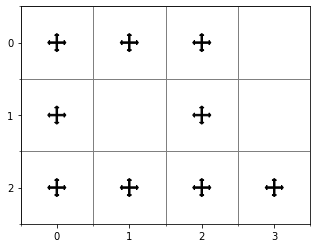

In [10]:
# let's create a random policy:
random_policy = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
random_policy = random_policy / lake_env.action_space.n

print("The random policy:")
print(random_policy)

print("\nLet's plot the random policy:")
fig, ax = plt.subplots()
plot_policy(ax, lake_env, random_policy)
plt.show()

We will use a 1 dimensional `np.array` to store value functions.

The length of this array is given by the number of states


A Value Function, initialized with 0:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Let's plot the all-zero value function:


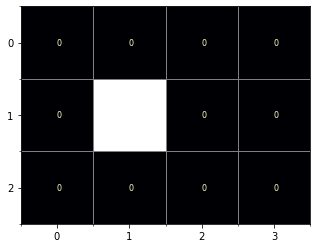

In [11]:
V = np.zeros(lake_env.observation_space.n)

print("\nA Value Function, initialized with 0:\n")
print(V)

print("\nLet's plot the all-zero value function:")
fig, ax = plt.subplots()
plot_value_function(ax, lake_env, V)
plt.show()

##  Policy Evaluation 
We will implement in-place version of policy evaluation

In [12]:
def policy_evaluation(env: gym.Env, policy: np.ndarray, initial_V: np.ndarray, gamma: float, theta: float = 1e-8) -> np.ndarray:
    """
    Policy Evaluation via Dynamic Programming
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        initial_V: the initial value function
        gamma: the discount factor
        theta: the stopping criterion (leave this alone)
    
    Returns:
        the value function for a given policy
    """
    V = initial_V.copy()

    num_states = env.observation_space.n
    num_actions = env.action_space.n

    delta = theta * 100    
    while delta > theta:
        delta = 0
        for state in range(num_states):
            new_state = 0
            for action in range(num_actions):
                prob_s_r = env.P[state][action]
                for dynamics in prob_s_r:
                    prob,next_state,reward,finish = dynamics
                    #if achieved the final point -> agent doesn't go to the next state
                    if finish:
                        new_state += policy[state,action] * prob * reward
                    else:
                        new_state += policy[state,action] * prob * (reward + gamma * V[next_state])
                
            delta = max(delta, np.abs(new_state - V[state])) 
            V[state] = new_state
    return V




In [13]:
# let's create a random policy:
random_policy = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
random_policy = random_policy / lake_env.action_space.n

# we will now evaluate the random policy, and obtain its associated value function
V_0 = np.zeros(lake_env.observation_space.n)
V_0 = policy_evaluation(lake_env, random_policy, V_0, gamma=0.9)

# at least one value should be different from the intial value, otherwise we assume it's not implemented/ incorrect ...
assert testing.is_type(V_0, np.ndarray)
assert testing.numpy_array_has_shape(V_0, (lake_env.observation_space.n,))
assert np.any(V_0 != 0), "your implementation of policy_evaluation returns the intial values without modifications"

### Run DP Policy Evaluation 
Okay, let's now run the implemented algorithm on the fishlake environment.

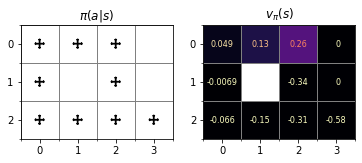

In [14]:
V = policy_evaluation(lake_env, random_policy, V_0, gamma=0.9)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, random_policy)

plot_value_function(axes[1], lake_env, V)
axes[0].set_title('$\pi(a | s)$')
axes[1].set_title('$v_{\pi}(s)$')
plt.show()

## Policy Improvement

Here you have to implement one step lookahead and the policy improvement algorithm. We will use policy improvement  later on within the policy iteration algorithm to compute the optimal policy.

Onset step lookahead computes the state-action values for a given state using the current state values and the dynamics. This is usefull in several dynamic programming algorithms.

In [15]:
def one_step_lookahead(env: gym.Env, state: int, V: np.ndarray, gamma: float) -> np.ndarray:
    """   
    
    Compute the action value q(s = state, a) for all actions a.
    
    Args:
        env: the openai gym environment
        state: index of the state in environment to compute the action vales for
        V: current value function
        gamma: discount factor
    
    Returns:
        a 1D numpy array containing the action values for state s
    """
    A = np.zeros(env.action_space.n)

    for action in range(env.action_space.n):
        prob_s_r = env.P[state][action]
        for dynamics in prob_s_r:
            prob,next_state,reward,finish = dynamics
            if finish:
                A[action] +=  prob * reward
            else:
                A[action] +=  prob * (reward + gamma * V[next_state])
    return A

In [16]:
gamma = 0.9
action_values = one_step_lookahead(lake_env, 0, np.ones(lake_env.observation_space.n), gamma)

assert testing.is_type(action_values, np.ndarray)
assert testing.numpy_array_has_shape(action_values, (lake_env.action_space.n,))
assert not all(action_values == 0), "initial values of action-values did not change but should"

In [17]:
def policy_improvement(env: gym.Env, old_policy: np.ndarray, V: np.ndarray, gamma: float) -> Tuple[np.ndarray, bool]:
    """
    Policy Improvement
    Args:
        env: the openai gym environment
        old_policy: the policy to be evaluated
        V: the value function of the policy
        gamma: discount factor
    
    Returns:
        a tuple consisting of the improved policy (a numpy array)
        and a boolean, indicating it the policy is stable (i.e. was not changed)
    """
    num_states = env.observation_space.n

    improved_policy = np.zeros_like(old_policy)
    policy_stable = True

    for state in range(num_states):
        action_old = np.argmax(old_policy[state])
        action_new = np.argmax(one_step_lookahead(env,state,V, gamma))
        
        #acting greadily
        improved_policy[state,action_new] = 1
        if action_old != action_new:
            policy_stable = False    
    
    return improved_policy, policy_stable

In [18]:
gamma = 0.9

# again, we start with a random policy
policy_0 = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
policy_0 = policy_0 / lake_env.action_space.n

# we will then evaluate the random policy and obtain its associated value function
V_0 = policy_evaluation(lake_env, policy_0, np.zeros(lake_env.observation_space.n), gamma=gamma)

# do one step of policy improvement
policy_1, policy_stable = policy_improvement(lake_env, policy_0, V_0, gamma=gamma)

# check data type of result
assert testing.is_type(policy_stable, bool)
assert testing.is_type(policy_1, np.ndarray)

# check if valid policy
assert testing.numpy_array_has_shape(policy_1, policy_0.shape)
assert np.isclose(policy_1.sum(axis=1), 1).all(), 'Probabilities of all actions must sum to one.'

# compute values for new policy
V_1 = policy_evaluation(lake_env, policy_1, V_0, gamma=gamma)

### Run Policy Improvement

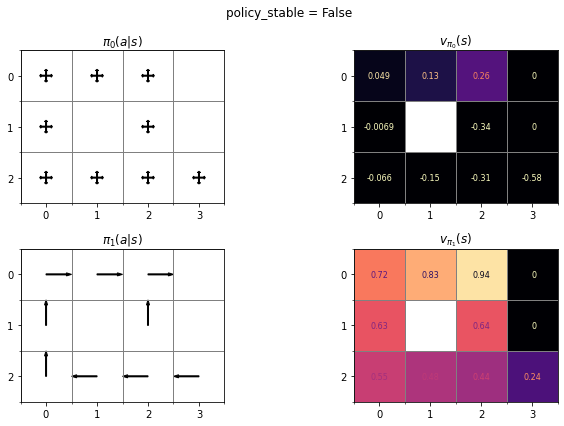

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.suptitle(f'policy_stable = {policy_stable}')
axes[0, 0].set_title('$\pi_0(a | s)$')
axes[0, 1].set_title('$v_{\pi_0}(s)$')
axes[1, 0].set_title('$\pi_1(a | s)$')
axes[1, 1].set_title('$v_{\pi_1}(s)$')

plot_policy(axes[0, 0], lake_env, policy_0)
plot_value_function(axes[0, 1], lake_env, V_0)
plot_policy(axes[1, 0], lake_env, policy_1)
plot_value_function(axes[1, 1], lake_env, V_1)
plt.tight_layout()
plt.show()

## Policy Iteration 

In [20]:
def policy_iteration(env: gym.Env, policy: np.ndarray, gamma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Policy Iteration
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        gamma: the discount factor
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    #1. initialize V(s) and policy(s) arbirtrarily:
    V = np.zeros(env.observation_space.n)
    policy = np.copy(policy)
    policy_stable = False

   
    while True:
        #2. Evaluation of the policy, obrain current estimate V:
        V = policy_evaluation(env, policy, V, gamma)
        #3. Improve policy:
        policy, policy_stable = policy_improvement(env, policy, V, gamma)
        if policy_stable:
            return policy, V
    


In [21]:
gamma = 0.9

# again, we start with a random policy
policy_0 = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
policy_0 = policy_0 / lake_env.action_space.n

# do policy iteration until convergence
policy_optimal, V_optimal = policy_iteration(lake_env, policy_0, gamma)

# check data type of result
assert testing.is_type(policy_optimal, np.ndarray)
assert testing.is_type(V_optimal, np.ndarray)

# check if valid policy and value array
assert testing.numpy_array_has_shape(policy_optimal, policy_0.shape)
assert testing.numpy_array_has_shape(V_optimal, (lake_env.observation_space.n,))

# some more checks ...
assert np.isclose(policy_1.sum(axis=1), 1).all(), 'Probabilities of all actions must sum to one.'
assert not np.isclose(policy_optimal, policy_0).all(), "Initial policy not updated."
assert not all(V_optimal == 0), "Initial values not updated."

### Run DP Policy Iteration

Next, let's improve a random policy and compute the optimal policy by using  policy iteration.

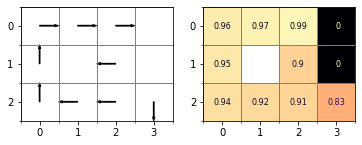

In [22]:
# let's create a random policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

# and now let's compute an optimal policy via the policy iteration algorithm
policy, value_function = policy_iteration(lake_env, policy, gamma=0.99)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, policy)
plot_value_function(axes[1], lake_env, value_function)
plt.show()

## Value Iteration 

In [24]:
def value_iteration(env: gym.Env, gamma: float, theta: float = 1e-8) -> Tuple[np.ndarray, np.ndarray]:
    """
    Value Iteration
    
    Args:
        env: the openai gym environment
        gamma: discount factor gamma
        theta: the stopping criterion
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    V = np.zeros(env.observation_space.n)
    policy = np.zeros([env.observation_space.n, env.action_space.n])

    num_states = env.observation_space.n
    num_actions = env.action_space.n
    delta = theta * 100
    while delta > theta:
        for state in range(num_states):
            delta = 0
            old_value = V[state]
            V[state] = max(one_step_lookahead(env,state,V, gamma))

            delta = max(delta,np.abs(old_value - V[state]))

    policy = policy_improvement(env,policy,V,gamma)[0]
    return policy, V

In [25]:
gamma = 0.9

policy_optimal, V_optimal = value_iteration(lake_env, gamma)

# check the results data type
assert testing.is_type(policy_optimal, np.ndarray)
assert testing.is_type(V_optimal, np.ndarray)

# check if valid policy and value array
assert testing.numpy_array_has_shape(policy_optimal, (lake_env.observation_space.n, lake_env.action_space.n))
assert testing.numpy_array_has_shape(V_optimal, (lake_env.observation_space.n,))

# some more checks ...
assert not all(V_optimal == 0), "Initial values not updated."
assert (policy_optimal.sum(axis=1) == 1).all(), 'Probabilities of all actions must sum to one.'

### Run DP Value Iteration

Finally, let's compute the optimal policy by using value iteration. Obviously the result should be very similar to the policy interation algorithm.

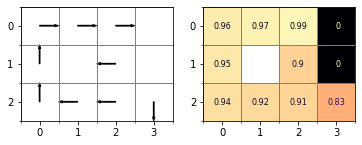

In [26]:
# let's redo this with value iteration...
opt_policy, opt_value_function = value_iteration(lake_env, gamma=0.99)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, opt_policy)
plot_value_function(axes[1], lake_env, opt_value_function)
plt.show()

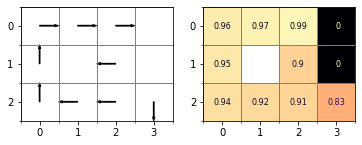

In [27]:
# let's redo this with value iteration...
opt_policy, opt_value_function = value_iteration(lake_env, gamma=0.99)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, opt_policy)
plot_value_function(axes[1], lake_env, opt_value_function)
plt.show()

## (5) Comprehension Exercise

Answer the following questions:

- Why does the optimal policy at the state in row 1, column 2 point to the left instead of up? Keep your answer short!

Because in the case of pointing to the left there is 0 probability to end up in fisherman state. 
Pointing up means, that there is only 0.8 probability to go up, and probability of ending up in fisherman state is 0.1.

Conclusion: pointing to the left is more safe

- Why is the expected future return not equal to 1 for every state?

Because of the gamma parameter(discount factor). Future rewards are multiplied by the discount factor, which in our case is equal to $0.99^k$. Plus dynamics are not deterministic: there is only 80% chance to go into the chosen direction. Plus only final steps have rewards either +1 or -1, others have 0 reward. All these factors make expectet future rewards not equal to 1 in all states

Consider the previous finite MDP. Specify whether the following statements are True or False:
1. If we set $\gamma$ to 1, a policy that moves down in state (2,3), left in state (1,2) and selects each action with a non-zero probability in all other states is optimal.
2. If we randomized the starting state and behave according to the optimal policy, the fish could get caught. Assume that we cannot start in a final state.
3. If we always stared in (0,0), all non-terminal states would be reachable under the optimal policy.

In [28]:
results = {
    '1': True,
    '2': False,
    '3': False
}

Specify whether the following statements are True or False **for MDPs in gerneral**:
1. There is exactly one optimal policy.
2. Adding a constant value to all rewards will not change the optimal policy in continuous tasks.
3. Adding a constant value to all rewards will not change the optimal policy in episodic tasks.
4. There can be more than one optimal value function.
5. $q_*(s, a)$ gives the value of taking the optimal action $a$ in state $s$ and following the optimal policy thereafter.

In [29]:
results = {
    '1': False,
    '2': True,
    '3': False,
    '4': False,
    '5': False
}
